# Linear elastic 2D truss {far}`star`

## Governing equations

We consider a truss $\Omega$ consisting of straight members, pinned at their extremities. The normal force $N$ in each member is related to the corresponding member axial strain $\varepsilon$ via a linear elastic relation:

$$
N = ES\varepsilon
$$

where $E$ is the material Young modulus, $S$ the member cross-section area and where the axial strain is given by the tangential displacement gradient along the member direction:

$$
\varepsilon = t\cdot\frac{du}{ds} = t\cdot\frac{du}{dx}\cdot t
$$

where $u$ is the truss displacement and $t = \frac{dx}{ds}$ is the member unit vector, $s$ being the curvilinear coordinate.

The weak form of equilibrium for the truss model is simply given by:

$$
\int_{\Omega} N\varepsilon[v]ds = \sum_i \boldsymbol{F}_i\cdot v_i \quad \forall v\in V
$$

where $v$ is a test function and $\boldsymbol{F}_i$ are concentrated external forces applied at nodes $i$.

## Implementation

### Geometry

In [14]:
import numpy as np
import pyvista
import gmsh
from mpi4py import MPI
from petsc4py import PETSc
import ufl
from dolfinx import fem, io, plot
import dolfinx.fem.petsc

We create the truss domain with the `Gmsh` Python API. Importantly, we generate a 1D mesh and add physical groups for nodes: `tag=1` for the left and right supports and `tag=2` for the bottom nodes for applied loading.

In [15]:
l = 5.0
h1 = 3.33
h2 = 5.33
h3 = 6.0

gmsh.initialize()
gmsh.option.setNumber("General.Terminal", 0)  # to disable meshing info
geom = gmsh.model.geo

left = geom.add_point(0.0, 0.0, 0.0)
right = geom.add_point(6 * l, 0.0, 0.0)
bottom_points = [
    geom.add_point(l, 0.0, 0.0),
    geom.add_point(2 * l, 0.0, 0.0),
    geom.add_point(3 * l, 0.0, 0.0),
    geom.add_point(4 * l, 0.0, 0.0),
    geom.add_point(5 * l, 0.0, 0.0),
]
top_points = [
    geom.add_point(l, h1, 0.0),
    geom.add_point(2 * l, h2, 0.0),
    geom.add_point(3 * l, h3, 0.0),
    geom.add_point(4 * l, h2, 0.0),
    geom.add_point(5 * l, h1, 0.0),
]
ext_bottom_points = [left] + bottom_points + [right]
ext_top_points = [left] + top_points + [right]

bottom_lines = [
    geom.add_line(ext_bottom_points[i], ext_bottom_points[i + 1])
    for i in range(len(ext_bottom_points) - 1)
]

top_lines = [
    geom.add_line(ext_top_points[i], ext_top_points[i + 1])
    for i in range(len(ext_top_points) - 1)
]

vertical_lines = [geom.add_line(p1, p2) for p1, p2 in zip(bottom_points, top_points)]

left_diagonal_lines = [
    geom.add_line(top_points[i], bottom_points[i + 1])
    for i in range(len(bottom_points) - 1)
]
right_diagonal_lines = [
    geom.add_line(bottom_points[i], top_points[i + 1])
    for i in range(len(bottom_points) - 1)
]
lines = (
    bottom_lines
    + top_lines
    + vertical_lines
    + right_diagonal_lines
    + left_diagonal_lines
)
geom.synchronize()

for l in lines:
    gmsh.model.mesh.set_transfinite_curve(l, 2)
gmsh.model.add_physical_group(0, bottom_points, 1)
gmsh.model.add_physical_group(0, [left] + [right], 2)
gmsh.model.add_physical_group(1, bottom_lines, 1)
gmsh.model.add_physical_group(1, top_lines
    + vertical_lines
    + right_diagonal_lines
    + left_diagonal_lines, 2)
gmsh.model.mesh.generate(dim=1)
gmsh.write("truss.msh")

domain, markers, facets = io.gmshio.model_to_mesh(gmsh.model, MPI.COMM_WORLD, 0, gdim=2)

gmsh.finalize()

In [16]:
gdim = domain.geometry.dim
tdim = domain.topology.dim

print(f"Geometrical dimension = {gdim}")
print(f"Topological dimension = {tdim}")

V = fem.functionspace(domain, ("CG", 1, (gdim,)))
Vv = fem.functionspace(domain, ("DG", 0, (gdim,)))

Geometrical dimension = 2
Topological dimension = 1


We now define the local tangent vector of the domain using `ufl.Jacobian` which returns the Jacobian $J=\dfrac{d\boldsymbol{x}}{dX}$ where $X$ denotes the 1D-coordinate of the reference unit interval. This vector aligns with the local truss element orientation. We then normalize the vector to obtain the unit tangent vector:

$$
\boldsymbol{t} = \dfrac{d\boldsymbol{x}}{ds} = \dfrac{1}{\left\|\frac{d\boldsymbol{x}}{dX}\right\|}\dfrac{d\boldsymbol{x}}{dX}
$$

In [17]:
dx_dX = ufl.Jacobian(domain)[:, 0]
t_ufl = dx_dX / ufl.sqrt(ufl.inner(dx_dX, dx_dX))
t = fem.Function(Vv, name="Tangent_vector")
t.interpolate(fem.Expression(t_ufl, Vv.element.interpolation_points()))

To apply point loads on the truss nodes, it will be more convenient to define a piecewise linear function `F` and set the corresponding degrees of freedom with the corresponding nodal forces. In this case, we apply vertical downwards concentrated forces of intensity 1 on the bottom nodes which we retrieve from the facet tag `1`. We also retrieve the left and right dofs for applying Dirichlet boundary conditions

In [18]:
F = fem.Function(V)
fdim = tdim - 1
load_dofs = fem.locate_dofs_topological(V.sub(1), fdim, facets.find(1))
F.x.array[load_dofs] = -1

bc_dofs = fem.locate_dofs_topological(V, fdim, facets.find(2))
bcs = [fem.dirichletbc(np.zeros((gdim,)), bc_dofs, V)]

We plot the mesh, the loading (in black) and the unit tangent vectors in red using `pyvista`.

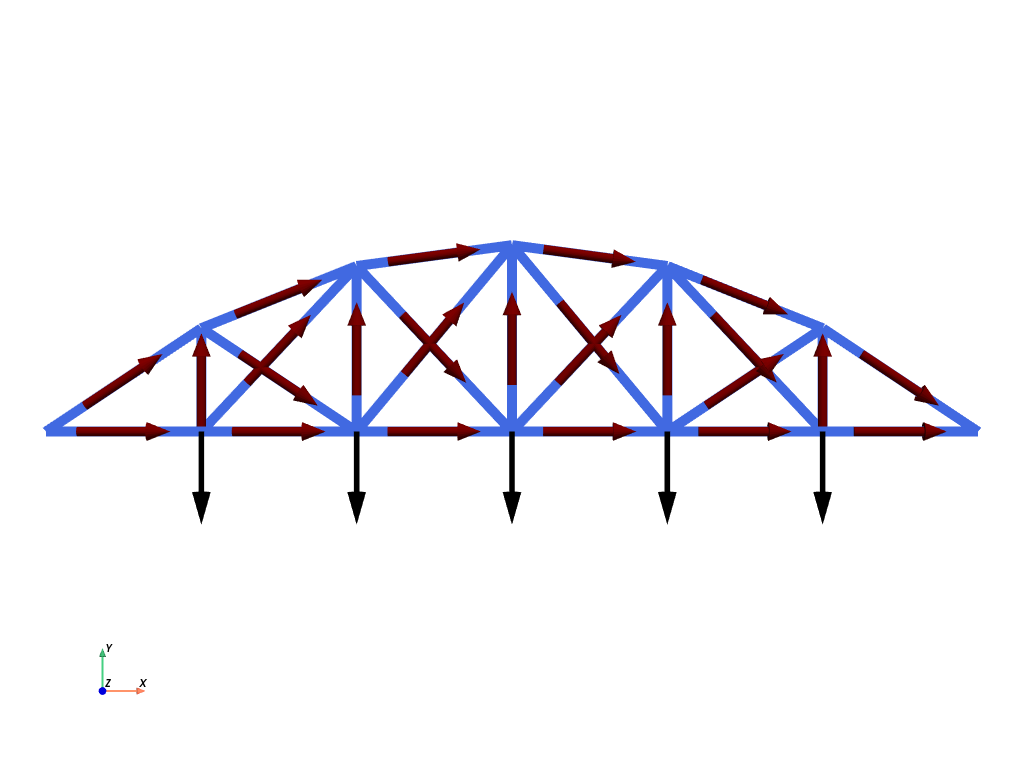

In [19]:
pyvista.set_jupyter_backend("static")
plotter = pyvista.Plotter()

u_topology, u_cell_types, u_geometry = plot.vtk_mesh(V)
u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
F_3D = np.zeros((u_geometry.shape[0], 3))
F_3D[:, :2] = F.x.array.reshape(-1, 2)
u_grid.point_data["F"] = F_3D
glyphs = u_grid.glyph(
    orient="F",
    factor=3.0,
)
plotter.add_mesh(glyphs, color="black")

grid = pyvista.UnstructuredGrid(*plot.vtk_mesh(domain))
plotter.add_mesh(grid, show_edges=True, line_width=10, color="royalblue")
t_3D = np.zeros((grid.n_cells, 3))
t_3D[:, :2] = t.x.array.reshape(-1, 2)
grid.cell_data["t"] = t_3D
grid.set_active_vectors("t")
arrow = pyvista.Arrow(
    start=(-0.5, 0, 0),
)
glyphs = grid.glyph(orient="t", factor=3.0, geom=arrow)

plotter.add_mesh(glyphs, color="darkred")
plotter.show_axes()
plotter.view_xy()
plotter.zoom_camera(1.3)
plotter.show()

### Define variational problem

We define the variational problem

In [30]:
du = ufl.TrialFunction(V)
u_ = ufl.TestFunction(V)
u = fem.Function(V, name="Displacement")

# E = fem.Constant(domain, 200e3)

n_edges = len(lines)
print(f"Number of trusses {n_edges}")


E = fem.Constant(domain, 200e3)

# S = fem.Constant(domain, 1.0)

V0 = fem.functionspace(domain, ("DG", 0, ()))
S  = fem.Function(V0)

S_array = 10*np.ones(n_edges)

with S.vector.localForm() as S_local:
    S_local[:] = S_array


def strain(u):
    return ufl.dot(ufl.dot(ufl.grad(u), t_ufl), t_ufl)


def normal_force(u):
    return E * S * strain(u)

dx = ufl.Measure("dx", subdomain_data=markers)
a_form = fem.form(ufl.inner(normal_force(du), strain(u_)) *dx)

Number of trusses 25


### Concentrated loadings

To define concentrated loadings, several (undirect) approaches can be used, considering the fact that point measures are not available. A first possibility is to define a distributed loading which when assembled into a global nodal forces vectors approximates the corresponding concentrated loading. A second approach is to assemble an empty nodal force vector and set the corresponding entries to the wanted concentrated loading. Below, we follow this approach. However, it prevents us from using the `LinearProblem` class and we must instead write the assembly and solve steps manually using `petsc4py`.

In [31]:
F0 = fem.Constant(domain, np.zeros((gdim,)))
L_form = fem.form(ufl.dot(F0, u_) * dx)

A = fem.petsc.assemble_matrix(a_form, bcs=bcs)
A.assemble()
b = fem.petsc.create_vector(L_form)

b.array[:] = F.x.array[:]

### Solving the problem

We finally setup the linear solver and solve the problem.

In [32]:
solver = PETSc.KSP().create(domain.comm)
solver.setOperators(A)
solver.setType(PETSc.KSP.Type.PREONLY)
solver.getPC().setType(PETSc.PC.Type.LU)

solver.solve(b, u.vector)
u.x.scatter_forward()


In [35]:
print(f"Numerical values of the displacement {u.vector.array}")


Numerical values of the displacement [ 4.03480699e-07 -4.74132401e-05  0.00000000e+00  0.00000000e+00
 -1.37161604e-05 -4.50337557e-05 -1.99417124e-07 -6.26991733e-05
 -8.86058546e-06 -5.90516462e-05  1.48004444e-20 -6.67384023e-05
 -1.38173109e-20 -6.31923170e-05  1.99417124e-07 -6.26991733e-05
  8.86058546e-06 -5.90516462e-05 -4.03480699e-07 -4.74132401e-05
  1.37161604e-05 -4.50337557e-05  0.00000000e+00  0.00000000e+00]


The normal force obtained from the elastic behavior is then interpolated onto a piecewise-constant function space.

In [33]:
N_exp = fem.Expression(normal_force(u), V0.element.interpolation_points())
N = fem.Function(V0, name="Normal_force")
N.interpolate(N_exp)

AWe plot the resulting normal force on the (scaled) deformed configuration using `pyvista`.

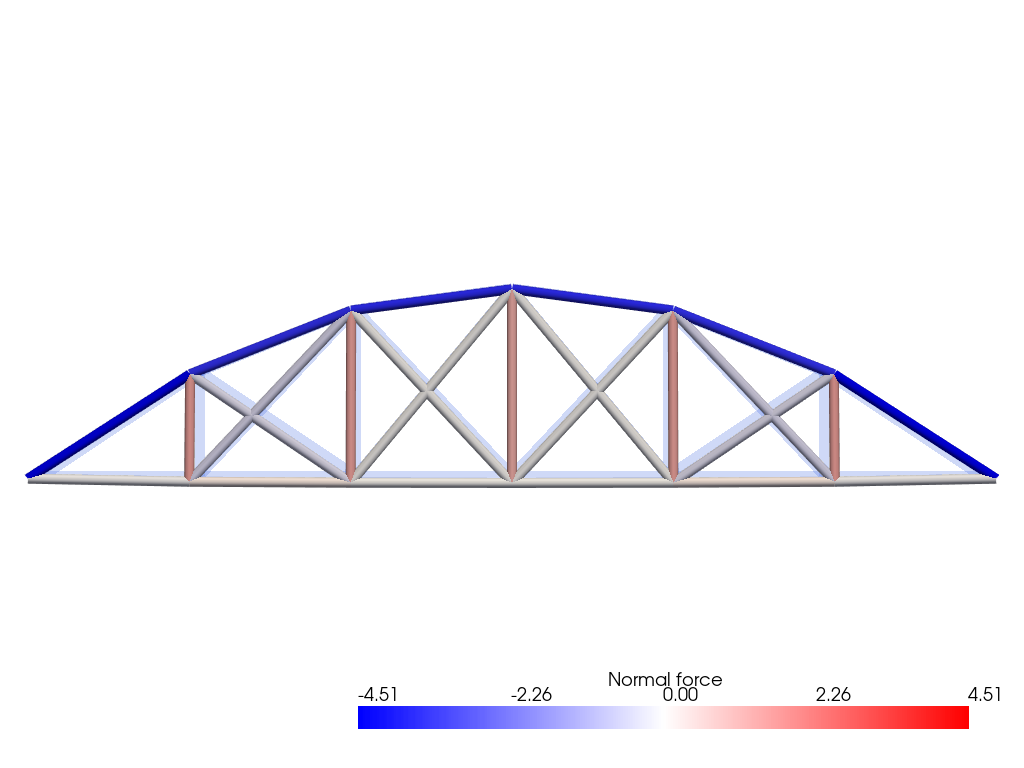

In [34]:
plotter = pyvista.Plotter()
u_topology, u_cell_types, u_geometry = plot.vtk_mesh(V)
u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_3D = np.zeros((u_geometry.shape[0], 3))
u_3D[:, :2] = u.x.array.reshape(-1, 2)
u_3D[:, 2] = (
    1e-3  # slightly offset to avoid overlap in xy view with underlying undeformed mesh
)
u_grid.point_data["Deflection"] = u_3D
u_grid.set_active_vectors("Deflection")
warped = u_grid.warp_by_vector("Deflection", factor=2000.0)
warped.cell_data["Normal force"] = N.x.array
plotter.add_mesh(
    u_grid, show_edges=True, line_width=10, color="royalblue", opacity=0.25
)

Nmax = max(abs(N.x.array))
plotter.add_mesh(
    warped,
    show_scalar_bar=True,
    scalars="Normal force",
    render_lines_as_tubes=True,
    style="wireframe",
    line_width=10,
    opacity=1,
    cmap="bwr",
    clim=[-Nmax, Nmax],
)
plotter.view_xy()
plotter.zoom_camera(1.3)
plotter.show()